## Background Information

The goal of this machine learning model is to accurately predict the outcome of NBA regular season games. 

Considerations:

- This model is only designed for regular season games, because historically NBA teams have been shown to perform significantly differently in the playoffs, which is why more advanced algorithms are often required to accurately predict playoff performance.
- This model will use the The "Four Factors of Basketball Success" to predict games. The "Four Factors of Basketball Success" were proposed in the early 2000's by Dean Oliver, a leading sports statistician, and include the four most impactful boxscore stats to determine a team's win probability. The stats are **effective field goal percentage (eFG%)**, **turnover percentage (TOV%)**, **offensive rebounding percentage (ORB%)**, and **Free Throw rate (FTr)**. This is a relatively simplistic, yet proven and effective method for determining game outcomes, so it is perfect for the task at hand.
- Because this model will be hosted on a website, I want to avoid using more advanced algorithms (neural networks, etc.) to predict games, as this can compromise on efficiency and user experience. Also, because I am a student and cannot afford to pay for cloud services to host my model, I will opt for simpler algorithm structures.

## Goal

- There is a notable home-court advantage in the NBA, with the home team typically winning roughly 57.2% of their games in a given season. A "baseline" model would always select the home team as the winner. 
- Traditionally, the NBA has an upset rate of between 28-32%, meaning that the "better" team wins 68-72% of the time. Because of this, it is very challenging to create a model with an accuracy higher than 68-72%. Given the limitations of the data, I hope to **achieve an accuracy that approaches falls within a 57% - 68% range**.

## Acknowledgements

- Luke Lite: https://github.com/luke-lite

## Import Statements and Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# Grab CSV file (containing four factor data) from Github

game_info = pd.read_csv('https://raw.githubusercontent.com/luke-lite/NBA-Prediction-Modeling/main/data/game_info.csv', index_col=0)
data = pd.read_csv('https://raw.githubusercontent.com/luke-lite/NBA-Prediction-Modeling/main/data/team_factor_20.csv', index_col=0)

In [4]:
data

,game_id,season,date,away_team,away_score,home_team,home_score,result,a_eFGp,a_FTr,a_ORBp,a_TOVp,h_eFGp,h_FTr,h_ORBp,h_TOVp
0,131410290001,1314,2013-10-29,ORL,87,IND,97,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,131410290002,1314,2013-10-29,CHI,95,MIA,107,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,131410290003,1314,2013-10-29,LAC,103,LAL,116,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,131410300004,1314,2013-10-30,BRK,94,CLE,98,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,131410300005,1314,2013-10-30,BOS,87,TOR,93,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11974,222304091226,2223,2023-04-09,UTA,117,LAL,128,1,0.531974,0.208931,0.26085,0.130643,0.551074,0.256529,0.25150,0.122359
11975,222304091227,2223,2023-04-09,NOP,108,MIN,113,1,0.559531,0.215249,0.22615,0.123621,0.558774,0.188976,0.21240,0.118801
11976,222304091228,2223,2023-04-09,MEM,100,OKC,115,1,0.574054,0.177729,0.22735,0.106729,0.519053,0.231355,0.24340,0.097976
11977,222304091229,2223,2023-04-09,LAC,119,PHO,114,0,0.578306,0.233759,0.22060,0.128125,0.541712,0.189901,0.25815,0.104120


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11979 entries, 0 to 11978
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   game_id     11979 non-null  int64  
 1   season      11979 non-null  int64  
 2   date        11979 non-null  object 
 3   away_team   11979 non-null  object 
 4   away_score  11979 non-null  int64  
 5   home_team   11979 non-null  object 
 6   home_score  11979 non-null  int64  
 7   result      11979 non-null  int64  
 8   a_eFGp      11966 non-null  float64
 9   a_FTr       11966 non-null  float64
 10  a_ORBp      11966 non-null  float64
 11  a_TOVp      11966 non-null  float64
 12  h_eFGp      11961 non-null  float64
 13  h_FTr       11961 non-null  float64
 14  h_ORBp      11961 non-null  float64
 15  h_TOVp      11961 non-null  float64
dtypes: float64(8), int64(5), object(3)
memory usage: 1.6+ MB


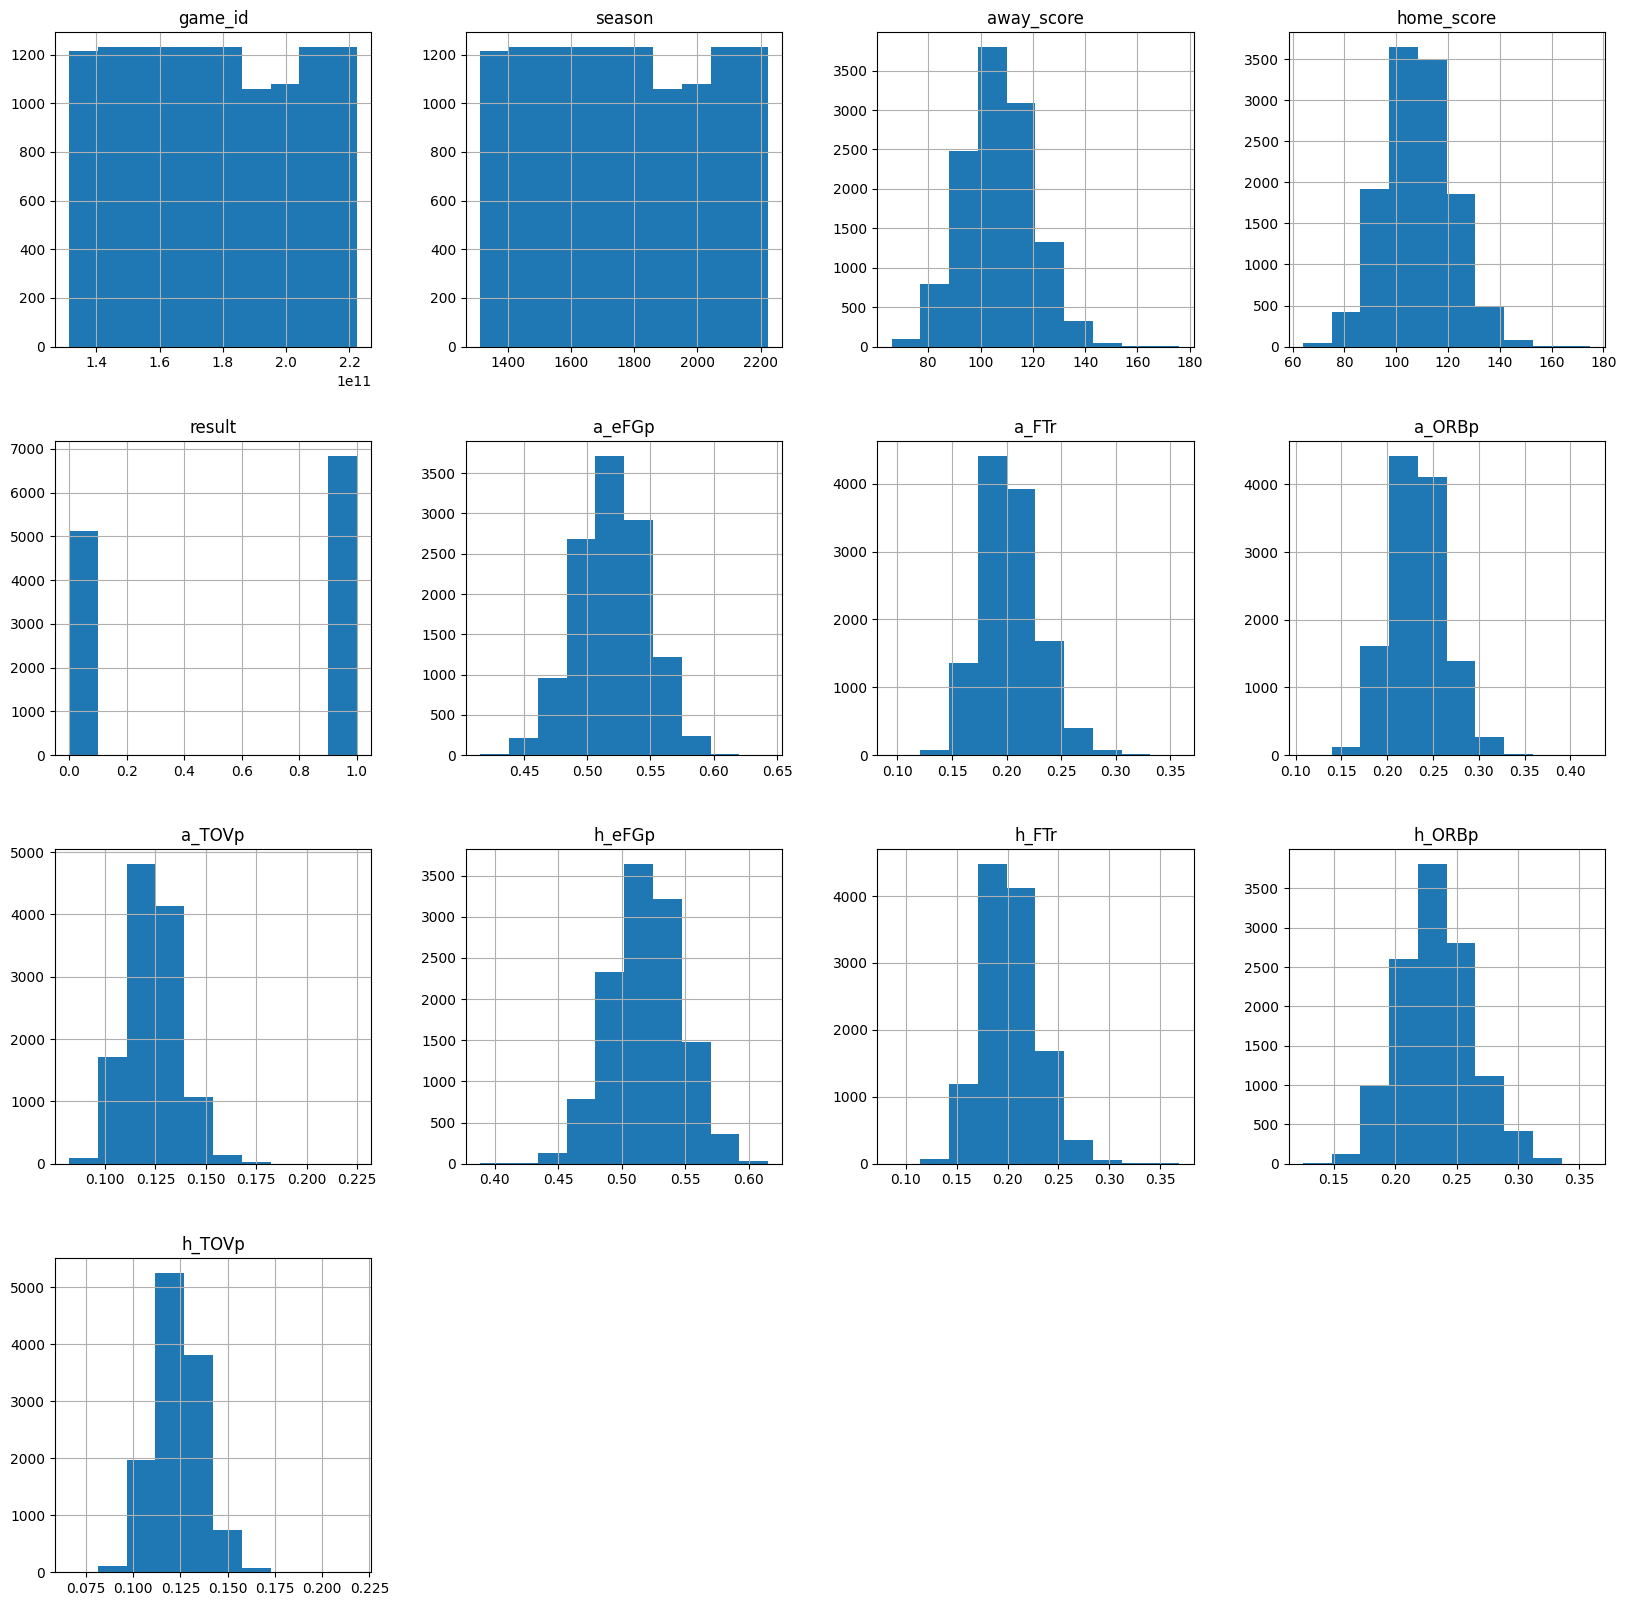

In [6]:
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data.hist(figsize=(20,20));

In [7]:
data['eFGp'] = data['a_eFGp'] - data['h_eFGp']
data['FTr'] = data['a_FTr'] - data['h_FTr']
data['ORBp'] = data['a_ORBp'] - data['h_ORBp']
data['TOVp'] = data['a_TOVp'] - data['h_TOVp']

results_df = pd.DataFrame(columns=['model_name', 'cv_score', 'gs_score', 'train_score', 'test_score'])

In [8]:
stat_columns = ['eFGp', 'FTr', 'ORBp', 'TOVp']

X = data[stat_columns]
y = data['result']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=99)

In [9]:
# Function to evaluate models
def evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    
    return {
        'model_name': model_name,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy
    }

In [10]:
# Initialize models
log_reg = LogisticRegression(max_iter=1000, random_state=99)
rf = RandomForestClassifier(random_state=99)
knn = KNeighborsClassifier()
svc = SVC(random_state=99)

In [11]:
# Evaluate models
models = [log_reg, rf, knn, svc]
model_names = ['Logistic Regression', 'Random Forest', 'KNN', 'SVC']

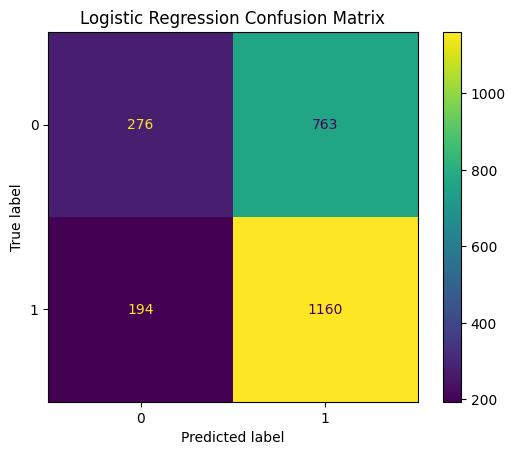

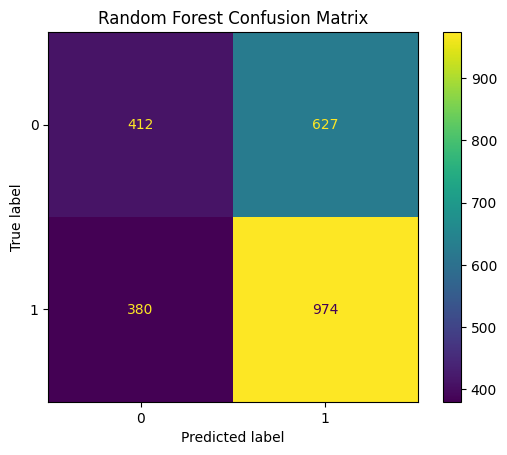

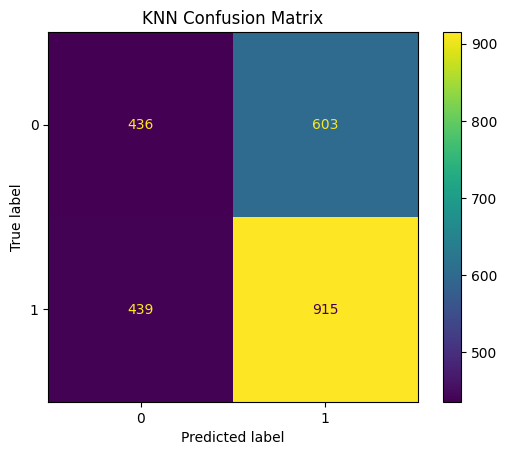

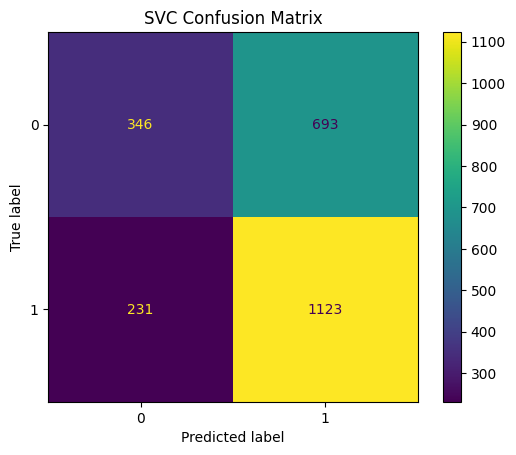

In [12]:
results = []

for model, name in zip(models, model_names):
    result = evaluate_model(model, name, X_train, X_test, y_train, y_test)
    results.append(result)

In [13]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

            model_name  train_accuracy  test_accuracy
0  Logistic Regression        0.620401       0.600084
1        Random Forest        1.000000       0.579189
2                  KNN        0.724498       0.564563
3                  SVC        0.633884       0.613874


## Further Improvements:

Given that all four models performed roughly similar, we will now only focus on optimizing the Logistic Regression Model. This is because the logistic regression model has the **lowest resource consumption** and **fastest speed** out of all four models, based on historical trends.

## Optimizing the Logistic Regression Model

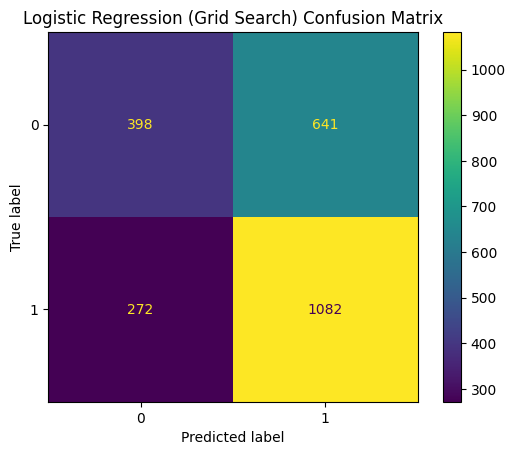

                          model_name  train_accuracy  test_accuracy
0                Logistic Regression        0.620401       0.600084
1                      Random Forest        1.000000       0.579189
2                                KNN        0.724498       0.564563
3                                SVC        0.633884       0.613874
4  Logistic Regression (Grid Search)        0.629390       0.618471


In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

# Define the logistic regression model
log_reg = LogisticRegression(solver='saga', random_state=99)

# Define the parameter grid for grid search
log_param_grid = {
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet', None],
    'logisticregression__C': [0.01, 0.1, 1.0],
}

# Create a pipeline with scaling and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logisticregression', log_reg)
])

# Perform grid search
grid_search = GridSearchCV(pipeline, log_param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_log_reg = grid_search.best_estimator_

# Evaluate the best model
y_pred_train = best_log_reg.predict(X_train)
y_pred_test = best_log_reg.predict(X_test)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Logistic Regression (Grid Search) Confusion Matrix')
plt.show()

# Update results
new_result = pd.DataFrame([{
    'model_name': 'Logistic Regression (Grid Search)',
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy
}])

results_df = pd.concat([results_df, new_result], ignore_index=True)

print(results_df)


## Next Steps

- With an optimized logistic regression model, we were able to obtain an **accuracy score of 62%**, falling within the threshold between 57% - 68%. 
- Now we can save this model and integrate it with our website (StatSwish)

In [15]:
import pickle

# Save the best logistic regression model to a file
with open('model2024.pkl', 'wb') as file:
    pickle.dump(best_log_reg, file)

# To load the model later
with open('model2024.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Example prediction using the loaded model
# Ensure the sample data has the correct number of features
sample_data = X_test.iloc[0].values.reshape(1, -1)

prediction = loaded_model.predict(sample_data)
print(f'Prediction: {prediction}')
print(f'Actual:', y_test[0])
print(X_test.iloc[0])

Prediction: [1]
Actual: 1
eFGp   -0.048624
FTr    -0.032726
ORBp   -0.014500
TOVp   -0.037343
Name: 1701, dtype: float64


In [17]:
# Predict probabilities
y_pred_proba = best_log_reg.predict_proba(X_test)

# Extract probabilities for class 1
probabilities_class_1 = y_pred_proba[:, 1]
probabilities_class_0 = y_pred_proba[:, 0]

# Example of output
for i in range(len(probabilities_class_1)):
    print(f"Sample {i}: P(Class 1) = {probabilities_class_1[i]:.2f}, P(Class 0) = {probabilities_class_0[i]:.2f}")


Sample 0: P(Class 1) = 0.69, P(Class 0) = 0.31
Sample 1: P(Class 1) = 0.51, P(Class 0) = 0.49
Sample 2: P(Class 1) = 0.58, P(Class 0) = 0.42
Sample 3: P(Class 1) = 0.55, P(Class 0) = 0.45
Sample 4: P(Class 1) = 0.48, P(Class 0) = 0.52
Sample 5: P(Class 1) = 0.63, P(Class 0) = 0.37
Sample 6: P(Class 1) = 0.54, P(Class 0) = 0.46
Sample 7: P(Class 1) = 0.36, P(Class 0) = 0.64
Sample 8: P(Class 1) = 0.61, P(Class 0) = 0.39
Sample 9: P(Class 1) = 0.33, P(Class 0) = 0.67
Sample 10: P(Class 1) = 0.44, P(Class 0) = 0.56
Sample 11: P(Class 1) = 0.76, P(Class 0) = 0.24
Sample 12: P(Class 1) = 0.63, P(Class 0) = 0.37
Sample 13: P(Class 1) = 0.40, P(Class 0) = 0.60
Sample 14: P(Class 1) = 0.58, P(Class 0) = 0.42
Sample 15: P(Class 1) = 0.51, P(Class 0) = 0.49
Sample 16: P(Class 1) = 0.55, P(Class 0) = 0.45
Sample 17: P(Class 1) = 0.62, P(Class 0) = 0.38
Sample 18: P(Class 1) = 0.64, P(Class 0) = 0.36
Sample 19: P(Class 1) = 0.42, P(Class 0) = 0.58
Sample 20: P(Class 1) = 0.55, P(Class 0) = 0.45
Sa